In [29]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
target_size = (244, 244)

train_dir = './../train_set/'
val_dir = './../val_set/'
test_dir = './../test_set/'

# scale images for vgg16 format
# train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

# read file from train_dir
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='binary')

Found 2002 images belonging to 2 classes.


In [31]:
batch = train_set.next() 
print('Data shape: ', batch[0].shape)
print('Label shape: ', batch[1].shape)

Data shape:  (32, 244, 244, 3)
Label shape:  (32,)


{'cat': 0, 'dog': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image batch shape:  (32, 244, 244, 3)
Label batch shape:  (32,)


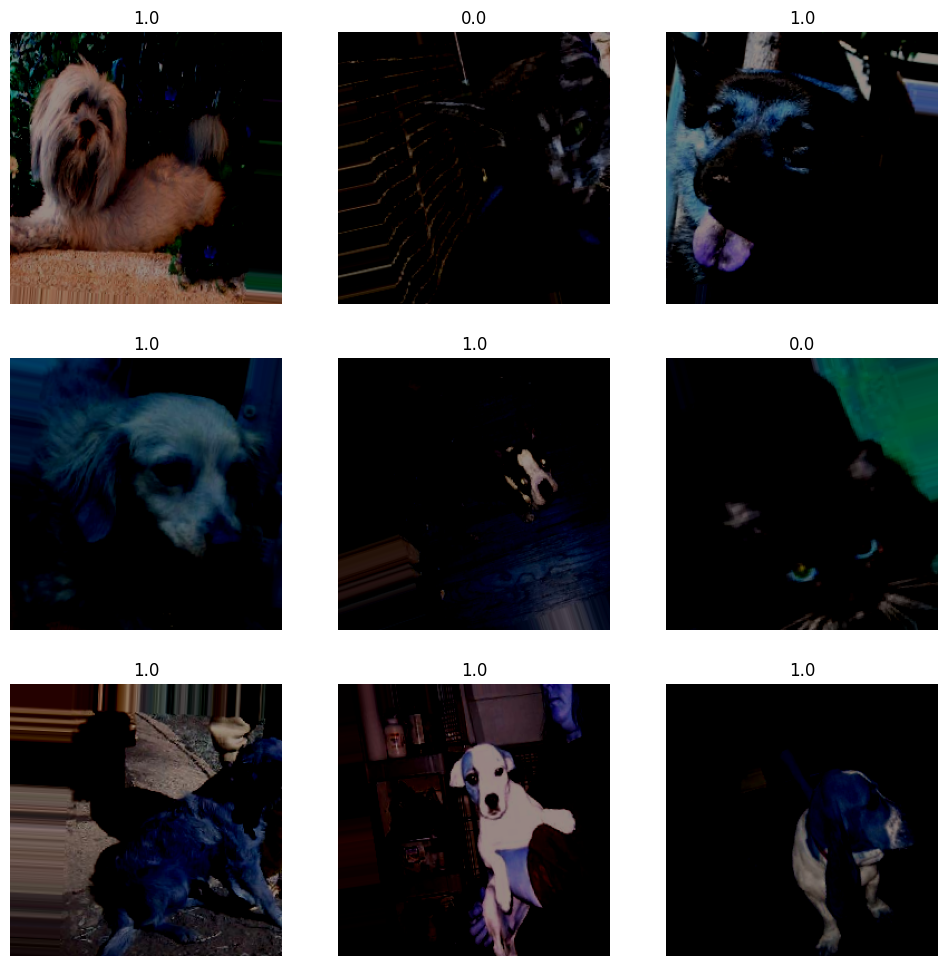

In [32]:
# visualize data
print(train_set.class_indices)
for image_batch, label_batch in train_set:
    print('Image batch shape: ', image_batch.shape)
    print('Label batch shape: ', label_batch.shape)
    plt.figure(figsize=(12, 12))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        plt.title(label_batch[i])
        plt.axis("off")
    break

In [33]:
# count 
ids, counts = np.unique(train_set.classes, return_counts=True)
print(ids)
print(counts)


[0 1]
[1001 1001]


In [34]:
# validation set
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_set = val_datagen.flow_from_directory(val_dir,
                                            target_size=target_size,
                                            batch_size=32,
                                            class_mode='binary')

Found 400 images belonging to 2 classes.


In [35]:
# count 
ids, counts = np.unique(val_set.classes, return_counts=True)
print(ids)
print(counts)

[0 1]
[200 200]


In [36]:
# create model
in_shape = (target_size[0], target_size[1], 3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=in_shape)

# summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [37]:
# create model
model = Sequential()

# add base model
model.add(base_model)

# add flatten layer
model.add(Flatten())

# add 128 dense layer
model.add(Dense(128, activation='relu'))

# add dropout
model.add(Dropout(0.5))

# add output layer
model.add(Dense(1, activation='sigmoid'))

# summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 17,926,209
Non-trainable params: 0
_________________________________________________________________


In [38]:
# trainable check
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg16 True
flatten_1 True
dense_2 True
dropout_1 True
dense_3 True


In [39]:
# lock base model
base_model.trainable = False

In [40]:
for variable in model.trainable_variables:
    print(variable.name, variable.trainable)

dense_2/kernel:0 True
dense_2/bias:0 True
dense_3/kernel:0 True
dense_3/bias:0 True


In [41]:
# summary after lock
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________


In [45]:
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# save weights
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint('vgg16_transfer.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')

# fit model
history = model.fit(train_set,
                    epochs=6,
                    validation_data=val_set,
                    callbacks=[es, mc])

Epoch 1/6


2023-10-26 12:19:30.477004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


63/63 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.8946

2023-10-26 12:25:04.298840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_accuracy improved from -inf to 0.89000, saving model to vgg16_transfer.h5
63/63 [==============================] - 400s 6s/step - loss: 0.2532 - accuracy: 0.8946 - val_loss: 16.7487 - val_accuracy: 0.8900
Epoch 2/6
63/63 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.8951
Epoch 2: val_accuracy improved from 0.89000 to 0.89500, saving model to vgg16_transfer.h5
63/63 [==============================] - 411s 7s/step - loss: 0.2390 - accuracy: 0.8951 - val_loss: 19.1663 - val_accuracy: 0.8950
Epoch 3/6
63/63 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.8921
Epoch 3: val_accuracy did not improve from 0.89500
63/63 [==============================] - 402s 6s/step - loss: 0.2488 - accuracy: 0.8921 - val_loss: 23.4997 - val_accuracy: 0.8875
Epoch 4/6
63/63 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.8886
Epoch 4: val_accuracy did not improve from 0.89500
63/63 [==============================] - 426s 7s

In [43]:
# evaluate model
score = model.evaluate(val_set)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2023-10-26 11:59:17.858637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 59s 5s/step - loss: 12.7709 - accuracy: 0.9050
Test loss: 12.770861625671387
Test accuracy: 0.9049999713897705


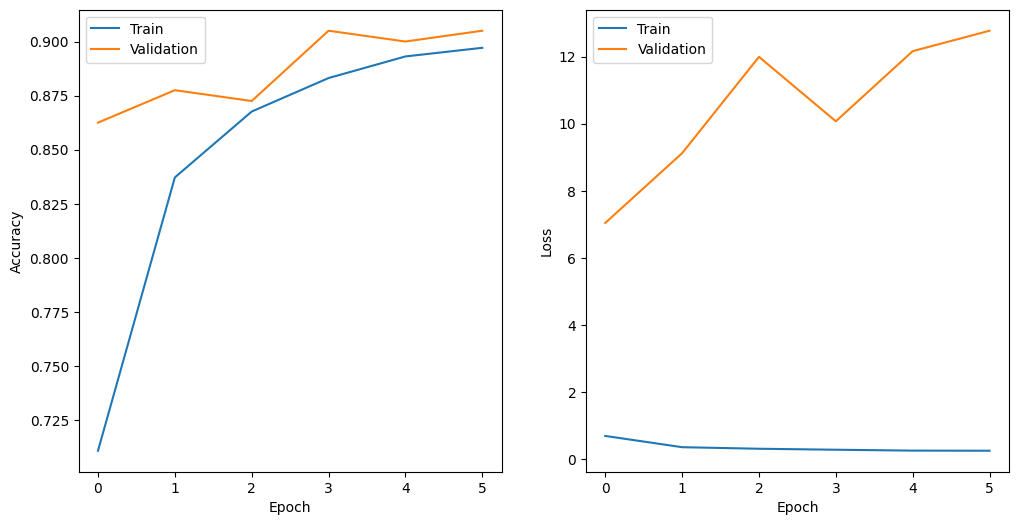

In [44]:
# plot accuracy and loss side by side
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
